In [1]:
import numpy as np
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
import string
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/spam.csv', encoding='ISO-8859-1')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


In [4]:
df.drop(columns=['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [5]:
df.sample(5)

,v1,v2
3683,ham,Dad says hurry the hell up
5495,ham,"Good afternoon, my love ... How goes your day ..."
2408,ham,Dear where you will be when i reach there
3292,ham,A little. Meds say take once every 8 hours. It...
4952,ham,I lost 4 pounds since my doc visit last week w...


In [6]:
df.rename(columns={'v1': 'target', 'v2': 'text'}, inplace=True)

In [7]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['target'])

In [8]:
# Missing values
df.isnull().sum()

target    0
text      0
dtype: int64

In [9]:
df.duplicated().sum()

403

In [10]:
df = df.drop_duplicates(keep='first')

In [11]:
df.shape

(5169, 2)

In [12]:
# Data is imbalanced
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\18raj\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [13]:
df['num_characters'] = df['text'].apply(len)

In [14]:
df.head()

,target,text,num_characters
0,0,"Go until jurong point, crazy.. Available only ...",111
1,0,Ok lar... Joking wif u oni...,29
2,1,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,0,U dun say so early hor... U c already then say...,49
4,0,"Nah I don't think he goes to usf, he lives aro...",61


In [15]:
# number of words
df['num_words'] = df['text'].apply(lambda x:len(nltk.word_tokenize(x)))
df['num_sentences'] = df['text'].apply(lambda x:len(nltk.sent_tokenize(x)))

In [16]:
df[['num_characters', 'num_words', 'num_sentences']].describe()

,num_characters,num_words,num_sentences
count,5169.000000,5169.000000,5169.000000
mean,78.977945,18.455794,1.965564
std,58.236293,13.324758,1.448541
min,2.000000,1.000000,1.000000
25%,36.000000,9.000000,1.000000
50%,60.000000,15.000000,1.000000
75%,117.000000,26.000000,2.000000
max,910.000000,220.000000,38.000000


In [17]:
def transform_text(text):
    # nltk.download('stopwords')
    ps = PorterStemmer()
    text = text.lower()
    text = nltk.word_tokenize(text)
    y = []
    for i in text:
        if i.isalnum():
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        if i not in stopwords.words('english') and i not in string.punctuation:
            y.append(i)
    text = y[:]
    y.clear()
    for i in text:
        y.append(ps.stem(i))
    return " ".join(y)

In [18]:
df['transformed_text'] = df['text'].apply(transform_text)

In [19]:
from wordcloud import WordCloud
wc = WordCloud(width=500, height=500, min_font_size=10,background_color='white')

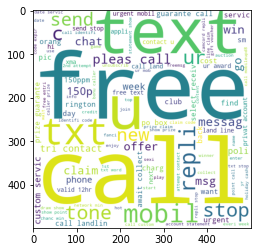

In [20]:
spam_wc = wc.generate(df[df['target'] == 1]['transformed_text'].str.cat(sep=" "))
plt.imshow(spam_wc)

In [21]:
spam_corpus = []
for msg in df[df['target'] == 1]['transformed_text'].tolist():
    for word in msg.split():
        spam_corpus.append(word)

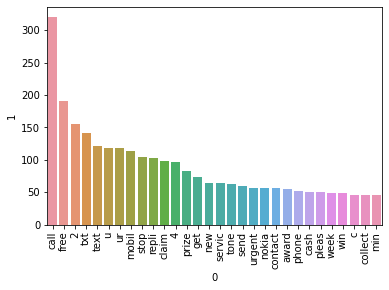

In [23]:
from collections import Counter
import seaborn as sns
sns.barplot(x=pd.DataFrame(Counter(spam_corpus).most_common(30))[0], y=pd.DataFrame(Counter(spam_corpus).most_common(30))[1])
plt.xticks(rotation='vertical')
plt.show()

In [30]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cv = CountVectorizer()
tfidf = TfidfVectorizer()

# X = cv.fit_transform(df['transformed_text']).toarray()
X = tfidf.fit_transform(df['transformed_text']).toarray()
y = df['target'].values

In [31]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

In [32]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

gnb = GaussianNB()
mnb = MultinomialNB()
bnb = BernoulliNB()

In [33]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score

gnb.fit(X_train, y_train)
y_pred1 = gnb.predict(X_test)
print(accuracy_score(y_test, y_pred1))
print(confusion_matrix(y_test, y_pred1))
print(precision_score(y_test, y_pred1))

0.8762088974854932
[[793 103]
 [ 25 113]]
0.5231481481481481


In [34]:
mnb.fit(X_train, y_train)
y_pred2 = mnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9593810444874274
[[896   0]
 [ 42  96]]
1.0


In [35]:
bnb.fit(X_train, y_train)
y_pred2 = bnb.predict(X_test)
print(accuracy_score(y_test, y_pred2))
print(confusion_matrix(y_test, y_pred2))
print(precision_score(y_test, y_pred2))

0.9700193423597679
[[893   3]
 [ 28 110]]
0.9734513274336283
